In [1]:
!pip install torchinfo

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Handling

## Downloading and loading the dataset

In [4]:
# Import CIFAR 100 Dataset

transform = transforms.Compose(
    [transforms.ToTensor()])

train_data = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

# Validation Split
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])

test_data = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                          shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64,
                                        shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64,
                                         shuffle=False, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12792632.81it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 342250.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3213804.24it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3053458.69it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Code to calculate mean and std of dataset

In [5]:
# from tqdm import tqdm

# def get_mean_std(loader):
#     # var[X] = E[X**2] - E[X]**2
#     channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

#     for data, _ in tqdm(loader):
#         channels_sum += torch.mean(data, dim=[0])
#         channels_sqrd_sum += torch.mean(data**2, dim=[0])
#         num_batches += 1

#     mean = channels_sum / num_batches
#     std = (channels_sqrd_sum / num_batches - mean**2) ** 0.5

#     return mean, std

# mean, std = get_mean_std(train_loader)
# print(mean, std)

# mean = (0.0144, -0.0263, -0.1174)
# std = (0.5346, 0.5129, 0.5522)

# Architecture

In [6]:
# Creating a model which has the option of including dense connections and batch normalization

import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, use_bn=True, dense=True):
        super(ConvBlock, self).__init__()
        self.use_bn = use_bn
        self.dense = dense
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=True)

    def forward(self, x):
        out = F.relu(self.conv(x))
        out = torch.cat([x, out], 1) if self.dense else out
        return out

class Net(nn.Module):
    def __init__(self, dense=True, input_size=32, input_channels=1, num_classes=10, outs=[8, 16, 32]):
        super(Net, self).__init__()
        self.dense = dense
        self.input_size = input_size
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.outs = outs

        for i in range(len(outs)):
            setattr(self, f'conv{i}', ConvBlock(input_channels, outs[i], 3, use_bn=True, dense=self.dense))
            input_channels = input_channels+outs[i] if self.dense else outs[i]

        self.classifier_head = nn.Sequential(
            nn.Conv2d(input_channels, self.num_classes, 1),
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        for i in range(len(self.outs)):
            x = getattr(self, f'conv{i}')(x)
        x = self.classifier_head(x)
        return x.view(-1, self.num_classes)


In [7]:
# A modular training function for clean code purpose

def train(model, train_loader, val_loader, num_epochs=5, lr=0.001, device=device):

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)

    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        curr_train_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            curr_train_loss += loss.item()*inputs.size(0)

        curr_train_loss = curr_train_loss/len(train_loader.dataset)
        train_losses.append(curr_train_loss)

        curr_val_loss = 0.0
        with torch.no_grad():
            model.eval()
            for data in val_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                curr_val_loss += loss.item()*images.size(0)

            curr_val_loss = curr_val_loss/len(val_loader.dataset)
            val_losses.append(curr_val_loss)

        print(f'Epoch {epoch+1}, Training Loss: {curr_train_loss}, Validation Loss: {curr_val_loss}')

    print('Finished Training')
    return model, train_losses, val_losses

In [8]:
# Evaluate using Confusion Matrix, F1 Score, Accuracy, Precision, Recall

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

def evaluate(model, test_loader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true += labels.cpu().numpy().tolist()
            y_pred += predicted.cpu().numpy().tolist()
    print(f'Confusion Matrix: \n{confusion_matrix(y_true, y_pred)}')
    print(f'F1 Score: {f1_score(y_true, y_pred, average="weighted")}')
    print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
    print(f'Precision: {precision_score(y_true, y_pred, average="weighted")}')
    print(f'Recall: {recall_score(y_true, y_pred, average="weighted")}')

# Training the Dense Version

In [9]:
num_epochs = 10
lr = 0.003

In [10]:
from torchinfo import summary

dense_net = Net(dense=True, input_size=28, input_channels=1, num_classes=10, outs=[8, 16, 32])
print(summary(dense_net, input_size=(16, 1, 28, 28)))

dense_net, dense_train_losses, dense_val_losses = train(dense_net, train_loader, val_loader, num_epochs=num_epochs, lr=lr)
evaluate(dense_net, test_loader)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [16, 10]                  --
├─ConvBlock: 1-1                         [16, 9, 28, 28]           --
│    └─Conv2d: 2-1                       [16, 8, 28, 28]           80
├─ConvBlock: 1-2                         [16, 25, 28, 28]          --
│    └─Conv2d: 2-2                       [16, 16, 28, 28]          1,312
├─ConvBlock: 1-3                         [16, 57, 28, 28]          --
│    └─Conv2d: 2-3                       [16, 32, 28, 28]          7,232
├─Sequential: 1-4                        [16, 10, 1, 1]            --
│    └─Conv2d: 2-4                       [16, 10, 28, 28]          580
│    └─AdaptiveAvgPool2d: 2-5            [16, 10, 1, 1]            --
Total params: 9,204
Trainable params: 9,204
Non-trainable params: 0
Total mult-adds (M): 115.45
Input size (MB): 0.05
Forward/backward pass size (MB): 6.62
Params size (MB): 0.04
Estimated Total Size (MB): 6.71
Epoch 1

## Plotting the Loss Curves

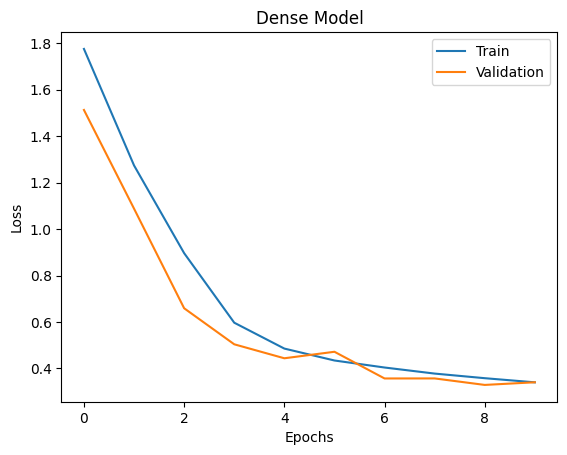

In [11]:
import matplotlib.pyplot as plt

plt.plot(dense_train_losses, label='Train')
plt.plot(dense_val_losses, label='Validation')
plt.title('Dense Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

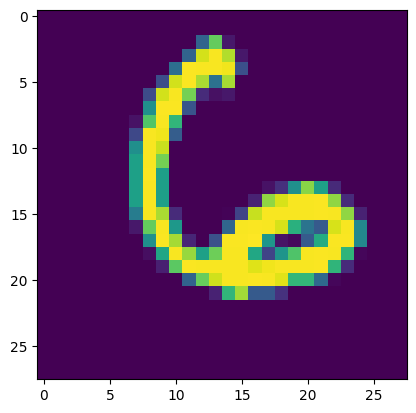

In [12]:
six_img = train_data[2300][0]
img = six_img.cpu().numpy()
transposed_image = np.transpose(img, (1, 2, 0))

# Display the image
plt.imshow(transposed_image[:, :, 0])  # Displaying as grayscale (assuming the first channel)
plt.show()

In [13]:
dense_net.eval()
six_img = six_img.unsqueeze(0)  # Adds a dimension at index 0
print(torch.argmax(dense_net(six_img.to(device)), dim = 1))
dense_net(six_img.to(device))

tensor([6], device='cuda:0')


tensor([[  3.3538,  -6.7410,  -0.1371, -10.4507,  -3.4279,  -0.2268,   4.8997,
          -8.2767,  -2.1731,  -3.4320]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [14]:
with open("image.h", 'w') as f:
    f.write("#include <iostream> \n")
    f.write("#include <vector> \n")
    f.write("using namespace std; \n")
    f.write("vector<vector<vector<float>>> image = {{ \n")
    for i in img[0]:
        f.write("{")
        for j in i:
            f.write(f"{j}, ")
        f.write("}, \n")
    f.write("}};")
    

In [15]:
# dense_net.state_dict()
model_parameters = {}
for name, param in dense_net.named_parameters():
    print(name)
    model_parameters[name] = param.cpu().detach().numpy()

value = " { "
# Write parameters to .h file
with open('model_params.h', 'w') as f:
    f.write('#ifndef MODEL_PARAMS_H\n')
    f.write('#define MODEL_PARAMS_H\n\n')
    f.write('#include <vector>\n\n')
    f.write('using namespace std;\n\n')

    for name, param in model_parameters.items():
        if("weight" in name):
            f.write(f'const vector<vector<vector<vector<float>>>> {name} = {value}\n')
            for item in param:
                f.write('{')
                for inner_item in item:
                    f.write('    {')
                    for sub_item in inner_item:
                        f.write('{')
                        for sub_sub_item in sub_item:
                            f.write(f'{sub_sub_item}, ')
                        f.write('}, ')
                    f.write('}, \n')
                f.write('}, \n')
            f.write('}; \n')
            
        else:
            f.write(f'const vector<float> {name} = \n')
            f.write('{\n')
            for item in param:
                f.write(f'{item}, ')
            f.write('};\n')

    f.write('#endif // MODEL_PARAMS_H\n')

conv0.conv.weight
conv0.conv.bias
conv1.conv.weight
conv1.conv.bias
conv2.conv.weight
conv2.conv.bias
classifier_head.0.weight
classifier_head.0.bias


# Training the Normal Version

In [16]:
normal_net = Net(dense=False, input_size=28, input_channels=1, num_classes=10, outs=[32, 64, 128, 256])
print(summary(normal_net, input_size=(16, 1, 28, 28)))

normal_net, normal_train_losses, normal_val_losses = train(normal_net, train_loader, val_loader, num_epochs=num_epochs, lr=0.003)
evaluate(normal_net, test_loader)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [16, 10]                  --
├─ConvBlock: 1-1                         [16, 32, 28, 28]          --
│    └─Conv2d: 2-1                       [16, 32, 28, 28]          320
├─ConvBlock: 1-2                         [16, 64, 28, 28]          --
│    └─Conv2d: 2-2                       [16, 64, 28, 28]          18,496
├─ConvBlock: 1-3                         [16, 128, 28, 28]         --
│    └─Conv2d: 2-3                       [16, 128, 28, 28]         73,856
├─ConvBlock: 1-4                         [16, 256, 28, 28]         --
│    └─Conv2d: 2-4                       [16, 256, 28, 28]         295,168
├─Sequential: 1-5                        [16, 10, 1, 1]            --
│    └─Conv2d: 2-5                       [16, 10, 28, 28]          2,570
│    └─AdaptiveAvgPool2d: 2-6            [16, 10, 1, 1]            --
Total params: 390,410
Trainable params: 390,410
Non-trainable params

## Plotting the Loss Curves

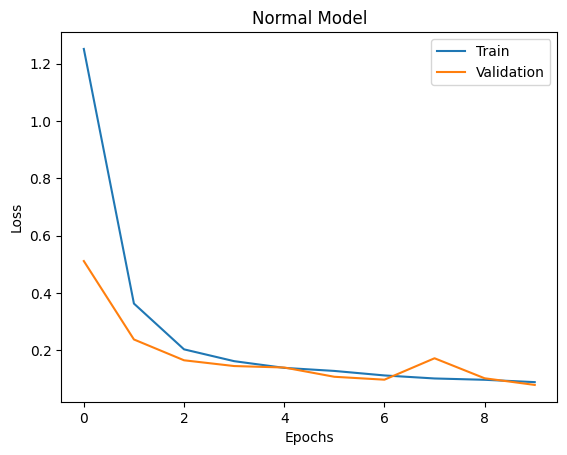

In [17]:
plt.plot(normal_train_losses, label='Train')
plt.plot(normal_val_losses, label='Validation')
plt.title('Normal Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Note on Comparison

**Macro F1:**

> Dense Version = 0.463

> Normal Version = 0.334

**Micro F1 (Accuracy):**
> Dense Version = 0.467

> Normal Version = 0.348

According to my opinion, this difference in results can be attributed to the 2 reasons briefly explained below:

1.   The dense connections facilitate better gradient flow, which mitigates the vanishing gradient flow problem.
2.   The inflow of previous inputs (in a fashion similar to Inception and Resnet) allows the model to look at multiple receptive fields at once. This ensures an enhanced understanding of the image, thereby increasing classification performance.



# Note on Architectural Choices

So, I have chosen to create 3 convolutional blocks, each containing a depthwise convolution layer, pointwise convolutional layer, batchnorm and ReLU. In case of the dense version, I am connecting all 3 blocks amongst themselves. So, technically, my whole model is a `DenseBlock`.

An alternative of this approach would be to include multiple such `DenseBlock`s along with `TransitionBlock`s. However, in my opinion, since the problem statement says that each convolution block should contain just 2 convolution layers (depthwise and pointwise), using dense connections inside these convolution blocks isn't a great idea.